## Analysis of the upper glycolysis subnetwork - Glucose substrate
#### Experiment code : SNMS30

In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns; sns.set_theme(style='ticks', context='paper')
import colorcet as cc
import glob

import toml

In [2]:
#Definition of constants
TIMEBIN = 90 #Binning (~45s)

### Isotopic ratios for isotopic correction (15N-Glu, NADH) ###
Glu_13C_isotope = 0.0546 # Percentage of signal of glutamate isotope (146) to remove from 15N-glutamate (147)
NAD_2_13C_isotope = 0.0245 # Percentage of signal of NAD isotope (662) to remove from NADH (664)
Glu_conc_ratio = 0.104429302 #Ratio of concentrations of glutamate (0.05517 mM) and 15N-glutamate (0.5283 mM)

### !!! In this experiment, the concentration of 15N-glutamate was not identical in all syringes !!!
### We will correct for it a dedicated cell

### NMR concentrations ###
F_concentration = 0.09288 # mM
G_concentration = 0.07956 # mM
G6P_concentration = 0.08957 # mM
F6P_concentration = 0.07707 # mM
FBP_concentration = 0.05594 # mM
ATP_concentration = 0.05 # mM
Pyr_concentration = 0.0912 # mM
Lac_concentration = 0.096288 # mM
PG_concentration = 0.088709 # mM
PEP_concentration = 0.09325 # mM

### Frag ratios ###
FBPtoF6P = 0.071
FtoLac = 0.058
GtoLac = 0.038

## Reading the data and conditions

In [3]:
flow_parameters = toml.load("conditions/SNMS30_flowparameters.toml")
inputs = np.array([[c['length'], c['syringe_parameters']['G']['reactor_concentration'], 
                    c['syringe_parameters']['ATP']['reactor_concentration'], 
                    c['syringe_parameters']['NAD']['reactor_concentration']] 
                    for c in flow_parameters['sections']
                ])

df_inputs = pd.DataFrame(
        inputs, columns=['time', 'G', 'ATP', 'NAD']
    ).assign(time = np.cumsum(inputs[:,0]))
print(df_inputs)
#correcting the inputs for time in minutes
df_inputgraph = df_inputs.copy()
df_inputgraph['time'] = (df_inputs['time'] / 60) - 90 #in minutes, minus the first 90 minutes of equilibration

      time     G  ATP   NAD
0      0.0  2.00  3.0  1.50
1  10800.0  2.00  3.0  1.50
2  14400.0  1.00  3.0  1.50
3  18000.0  0.50  3.0  1.50
4  21600.0  0.25  3.0  1.50
5  25200.0  2.00  1.0  1.50
6  28800.0  1.00  1.0  1.50
7  32400.0  0.50  1.0  1.50
8  36000.0  0.25  1.0  1.50
9  39600.0  2.00  3.0  0.75


In [4]:
files = pathlib.Path(f"data/SNMS30/").glob('*.xy')

sumdf = pd.DataFrame()
    
try:
    with open(f"data/SNMS30/TIC.xy",'r') as fin:
        df = pd.read_csv(fin, sep=' ', names=['Time','TIC'])
        df_TICSamp1 = df['Time'].groupby(df.index // TIMEBIN).min()
        df_TICSamp2 = df['TIC'].groupby(df.index // TIMEBIN).sum()
        df_TICSamp = pd.concat([df_TICSamp1,df_TICSamp2], axis=1)
                    
except FileNotFoundError:
    print("No TIC files here!")
    
df_Time = df_TICSamp['Time']

sumdf["retention_time"] = df_Time
        
fileList=glob.glob(f"data/SNMS30/*.xy")
fileList.remove(f"data/SNMS30\\TIC.xy")
    
for file in fileList:
    try:
        with open(file,'r') as fin:
            df_file = pd.read_csv(fin, sep=' ', names=['Time','IC'])

            ionname = pathlib.Path(file).stem
            
            #binning
            df_Samp1 = df_file['Time'].groupby(df_file.index // TIMEBIN).min()
            df_Samp2 = df_file['IC'].groupby(df_file.index // TIMEBIN).sum()
            df_Samp = pd.concat([df_Samp1,df_Samp2], axis=1)

            #TIC corr
            df_SampTIC = df_Samp['IC'] / df_TICSamp['TIC']
            df_SampTIC.name = ionname

            sumdf[ionname] = df_SampTIC
    except FileNotFoundError:
        print("Missing files")

    
sumdf = sumdf.assign(retention_time = sumdf.retention_time.round(1))
sumdf = sumdf.set_index('retention_time')
#print(sumdf)

In [5]:
### Correction for the uneven Glu-15N concentrations in the syringes
#We will divide for the real concentration of Glu-15N fed to the CSTR and multiply by the correct concentration (0.5 mM)

list_conc_L_glu = [0.575, 0.7, 0.7625, 0.79375, 0.655, 0.78, 0.8425, 0.87375, 0.545, 0.67]
SSTIMES = df_inputs["time"].tolist()
real_glu_df = pd.DataFrame()
real_glu_df["time"] = sumdf.index
real_glu_df.loc[real_glu_df.index.min(),"L_Glu_conc"] = list_conc_L_glu[0]

i = 1
while i < (len(list_conc_L_glu)):
    conc = list_conc_L_glu[i]
    time = SSTIMES[(i)] + 1200 #offset between timstof and labm8
    real_glu_df.loc[(real_glu_df["time"] - time).abs().argsort()[:2],"L_Glu_conc"] = conc  
    i+=1

real_glu_df.loc[real_glu_df.index.min(),"target_conc"] = 0.5
real_glu_df = real_glu_df.ffill()
real_glu_df["ratio"] = real_glu_df["L_Glu_conc"]/real_glu_df["target_conc"]
real_glu_df.index = sumdf.index 

sumdf["L_Glu_corr"] = (sumdf["L_Glu"] - (Glu_13C_isotope*sumdf["Glu"])) / real_glu_df["ratio"] 
#Correction for both isotope and wrong 15-N-glu concentration

#Calculation of the flow ratios between dilution line and reactor
sumdf["Flow ratio"] = (sumdf["L_Glu_corr"]/sumdf["Glu"])*(Glu_conc_ratio)
sumdf["Flow ratio"].replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0

### Getting the metabolite concentrations
#### Making Figure 2 - Panels c,d,e,f

In [6]:
quantif_df = pd.DataFrame()
quantif_df.index = sumdf.index
quantif_df['G'] = (sumdf['L_G'] / sumdf['G'])*(G_concentration / sumdf["Flow ratio"])
quantif_df['ATP'] = (sumdf['ATP_2+'] / sumdf['L_ATP_2+'])*(ATP_concentration / sumdf["Flow ratio"])
quantif_df['NADH'] = (sumdf['NADH'] - NAD_2_13C_isotope*sumdf['NAD']) / 0.00302201 #Value determined in SNMS32
quantif_df['G6P'] = (sumdf['L_G6P'] / sumdf['G6P'])*(G6P_concentration / sumdf["Flow ratio"])
quantif_df['F6P'] = ((sumdf['L_F6P']) / (sumdf['F6P'] - (FBPtoF6P*sumdf['FBP'])))*(F6P_concentration / sumdf["Flow ratio"]) #With FBP to F6P correction
quantif_df.replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0
quantif_df.index = quantif_df.index / 60 #s to min
quantif_df.index = quantif_df.index - 90 #removing the first 90 minutes of equilibration

C:\Users\qduez\AppData\Local\Temp\ipykernel_4148\2886373006.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputgraph, x="time", y="G", drawstyle='steps', alpha=1, ax=ax[0,0], linewidth=1.5, label="G", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_4148\2886373006.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputgraph, x="time", y="ATP", drawstyle='steps', alpha=1, ax=ax[0,0], linewidth=1.5, label="ATP", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_4148\2886373006.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputgraph, x="time", y="NAD", drawstyle='steps', alpha=1, ax=ax[0,0], linewidth=1.5, label="NAD", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_4148\2886373006.py:19: UserWarning: 
The markers list has fewer values (1) than needed (5) and will cycle

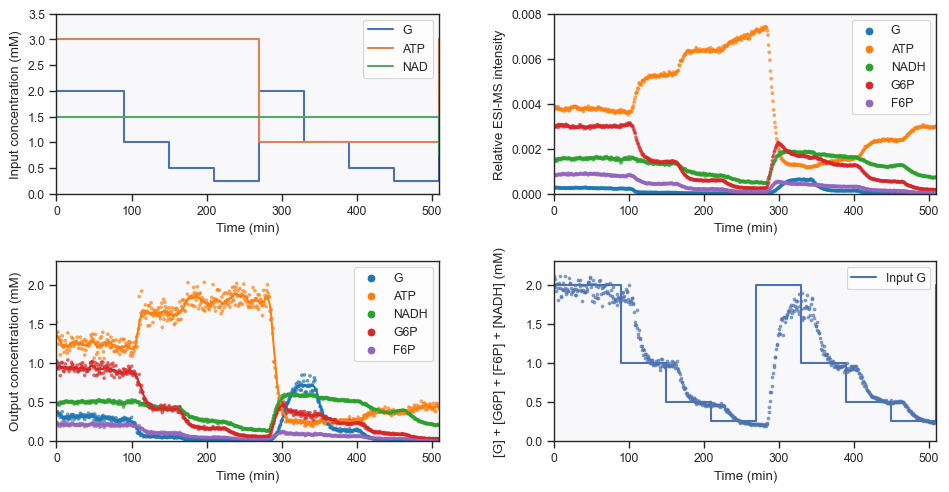

In [7]:
int_df = pd.DataFrame()
int_df['G'] = sumdf['L_G']
int_df['ATP'] = sumdf['ATP_2+'] 
int_df['NADH'] = sumdf['NADH']
int_df['G6P'] = sumdf['L_G6P'] 
int_df['F6P'] = sumdf['L_F6P']
int_df.index = (sumdf.index / 60)-90 #in minutes, minus the first 90 minutes of equilibration

rolled_df = quantif_df.rolling(10, center=True).mean()

totaldf = pd.DataFrame()
totaldf = (quantif_df['NADH'] + quantif_df['G'] + quantif_df['G6P'] + quantif_df['F6P'])

fig, ax = plt.subplots(2,2)
sns.lineplot(data = df_inputgraph, x="time", y="G", drawstyle='steps', alpha=1, ax=ax[0,0], linewidth=1.5, label="G", palette="tab10")
sns.lineplot(data = df_inputgraph, x="time", y="ATP", drawstyle='steps', alpha=1, ax=ax[0,0], linewidth=1.5, label="ATP", palette="tab10")
sns.lineplot(data = df_inputgraph, x="time", y="NAD", drawstyle='steps', alpha=1, ax=ax[0,0], linewidth=1.5, label="NAD", palette="tab10")

sns.scatterplot(int_df, alpha=0.7, ax=ax[0,1], s=7, markers=["o"], palette="tab10", linewidth=0)
sns.scatterplot(quantif_df, alpha=0.7, ax=ax[1,0], s=7, markers=["o"], palette="tab10", linewidth=0)
sns.lineplot(rolled_df, dashes=False, alpha=1, ax=ax[1,0], linewidth=1.5, legend=None, palette="tab10")
sns.scatterplot(totaldf, alpha=0.7, legend=None, ax=ax[1,1], s=7, palette="tab10", linewidth=0)
sns.lineplot(data = df_inputgraph, x="time", y="G", drawstyle='steps', alpha=1, ax=ax[1,1], linewidth=1.5, label="Input G", palette="tab10")

ax[0,0].set_xlim(0,510)
ax[0,1].set_xlim(0,510)
ax[1,0].set_xlim(0,510)
ax[1,1].set_xlim(0,510)

ax[0,0].set_ylim(0,3.5)
ax[0,1].set_ylim(0,0.008)
ax[1,0].set_ylim(0,2.3)
ax[1,1].set_ylim(0,2.3)


ax[0,0].set_xlabel("Time (min)")
ax[0,1].set_xlabel("Time (min)")
ax[1,0].set_xlabel("Time (min)")
ax[1,1].set_xlabel("Time (min)")

ax[0,0].set_ylabel("Input concentration (mM)")
ax[0,1].set_ylabel("Relative ESI-MS intensity")
ax[1,0].set_ylabel("Output concentration (mM)")
ax[1,1].set_ylabel("[G] + [G6P] + [F6P] + [NADH] (mM)")

fig.align_ylabels(ax[:, 1])
ax[0,0].set_facecolor('#F8F8FB')
ax[0,1].set_facecolor('#F8F8FB')
ax[1,0].set_facecolor('#F8F8FB')
ax[1,1].set_facecolor('#F8F8FB')

plt.subplots_adjust(left=None, bottom=None, right=1.5, top=1.0, wspace=0.3, hspace=0.375)
#plt.savefig('SNMS30.svg', format='svg', bbox_inches='tight', dpi=600)

### Getting the intensities of the metabolites we do not quantify
#### Making Figure S2

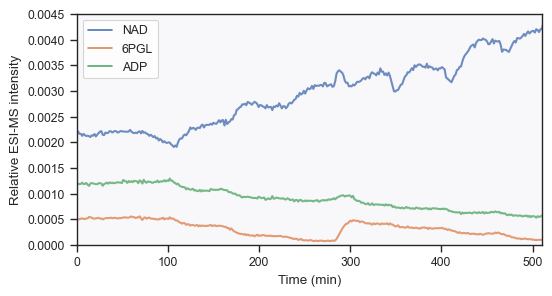

In [8]:
intensity_df = pd.DataFrame()
intensity_df.index = sumdf.index
intensity_df["NAD"] = sumdf["NAD"]
intensity_df["6PGL"] = sumdf["6PGL"]
intensity_df["ADP"] = sumdf["ADP"]

#binning
df_Time_Samp = intensity_df.groupby(intensity_df.index // TIMEBIN).min()
df_intensity_Samp =  intensity_df.groupby(intensity_df.index // TIMEBIN).mean()

df_intensity_Samp.index = (df_Time_Samp.index * TIMEBIN/60) - 90 #in minutes, minus the first 90 minutes of equilibration

fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(df_intensity_Samp, dashes=False, alpha=0.8, linewidth=1.5)
ax.set_xlim(0,510)
ax.set_ylim(0,0.0045)
#ax.set_yscale("log")
ax.set_xlabel("Time (min)")
ax.set_ylabel("Relative ESI-MS intensity")
ax.set_facecolor('#F8F8FB')
#plt.savefig('SNMS30_SI_intensities.png', format='png', bbox_inches='tight', dpi=600)